IntSlider(value=1000, description='Trials:', max=5000, min=100, step=100)

IntSlider(value=365, description='Days:', max=730, min=30, step=30)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


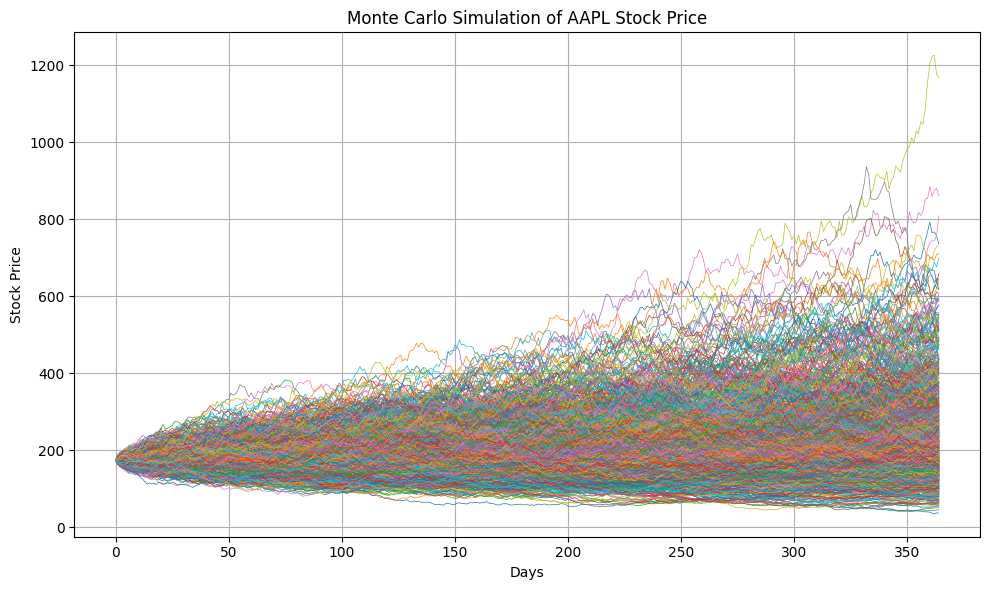

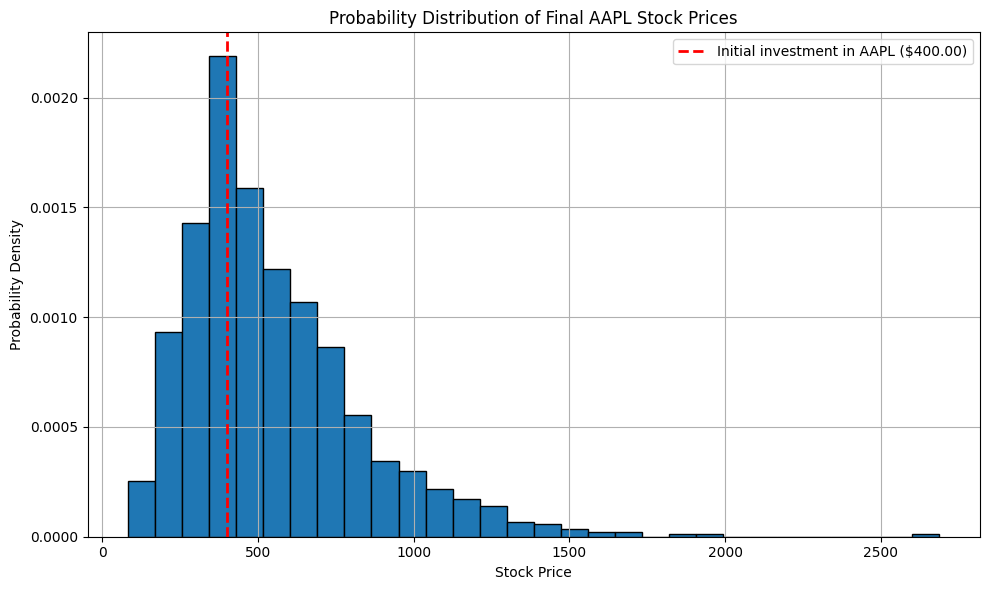

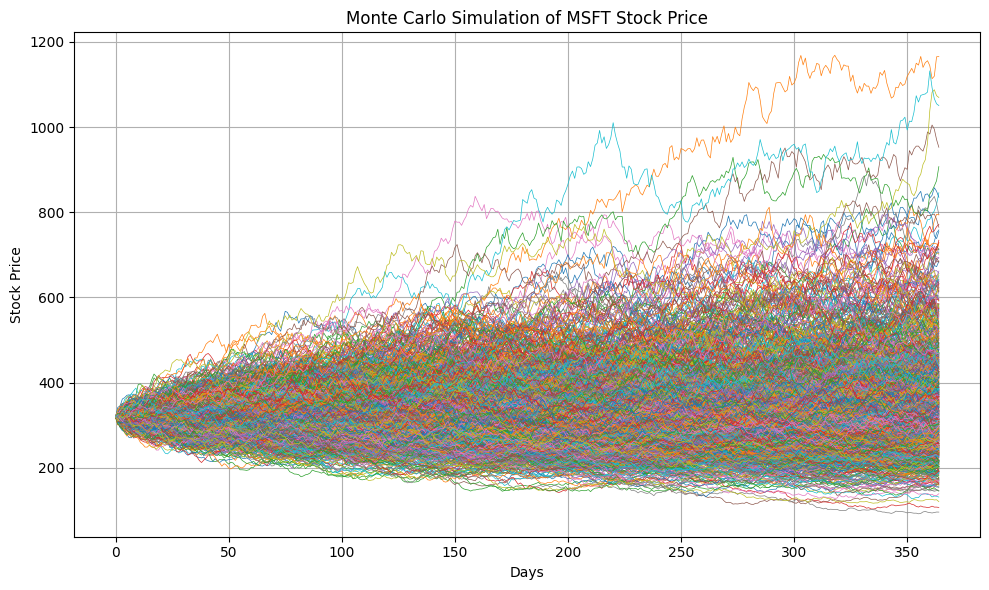

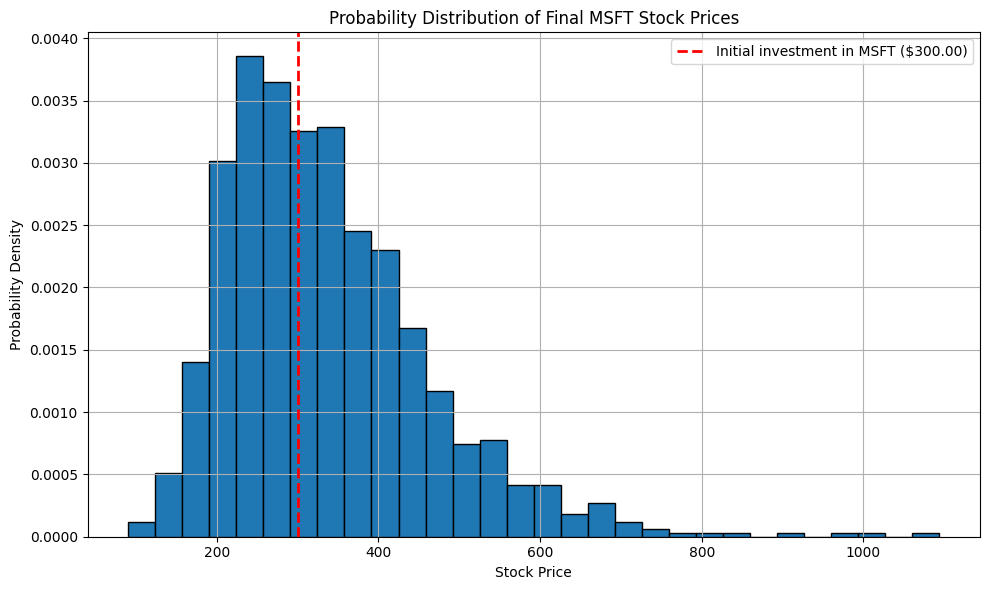

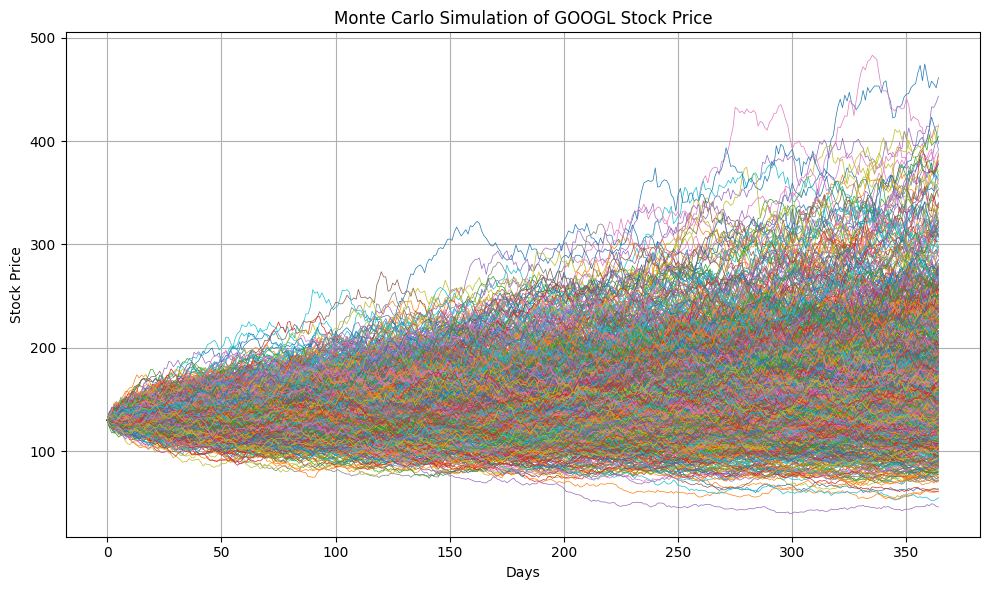

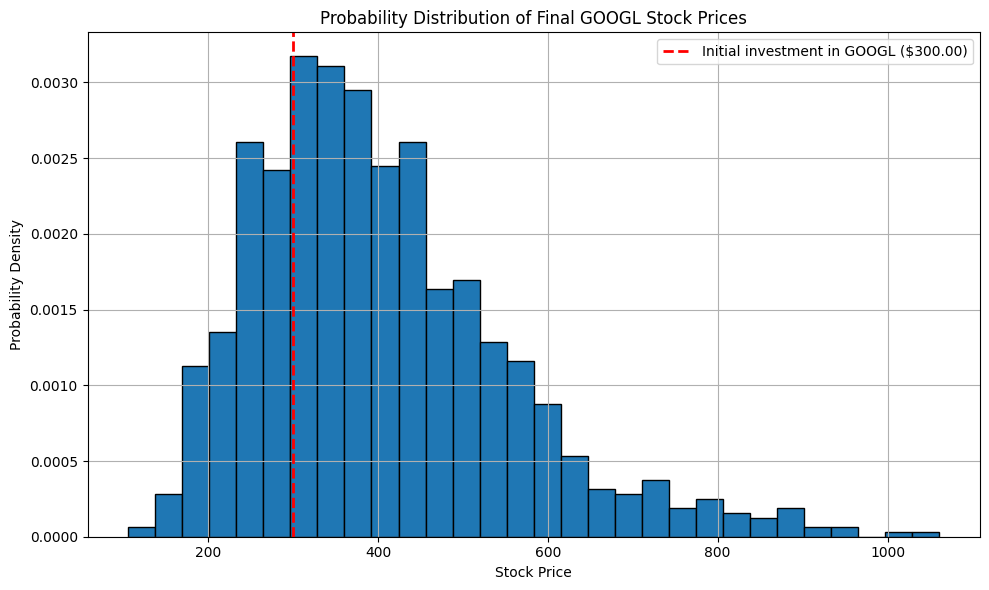

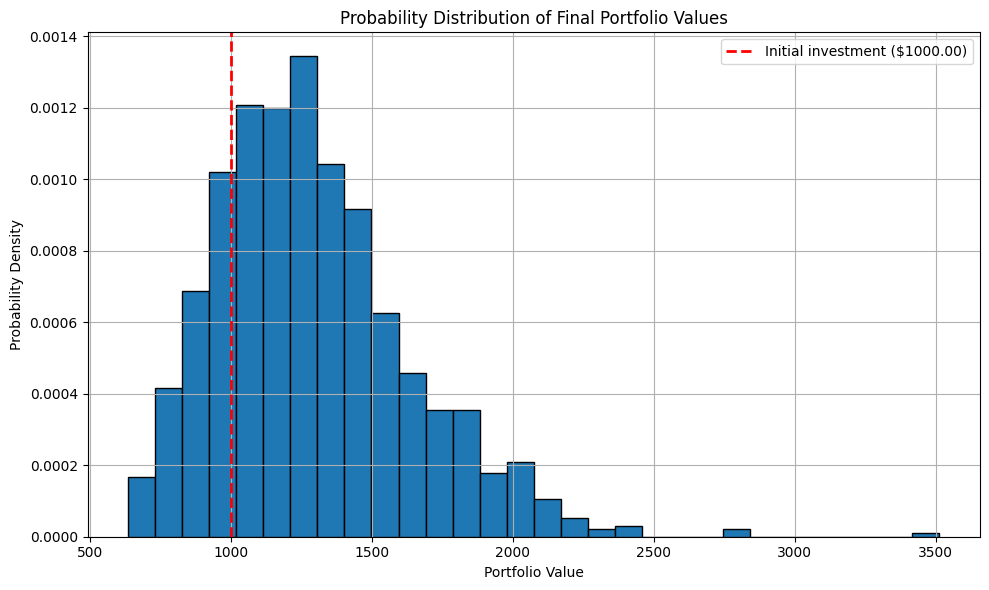

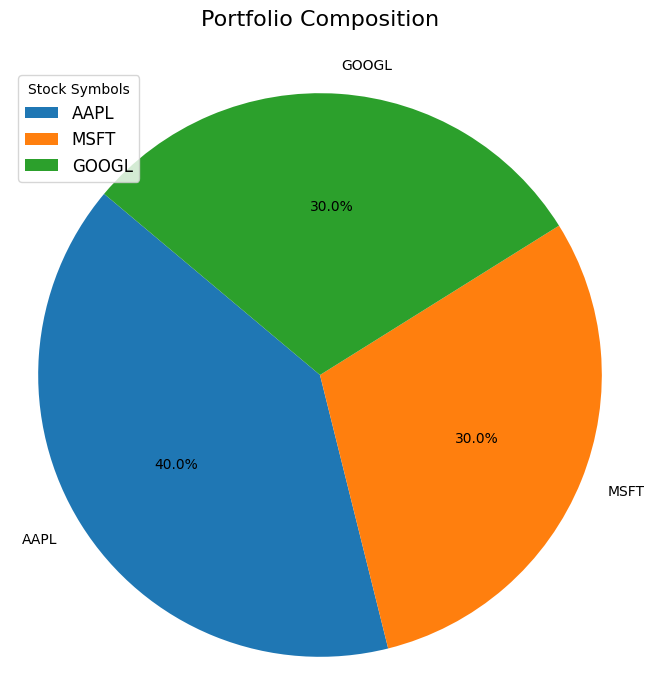

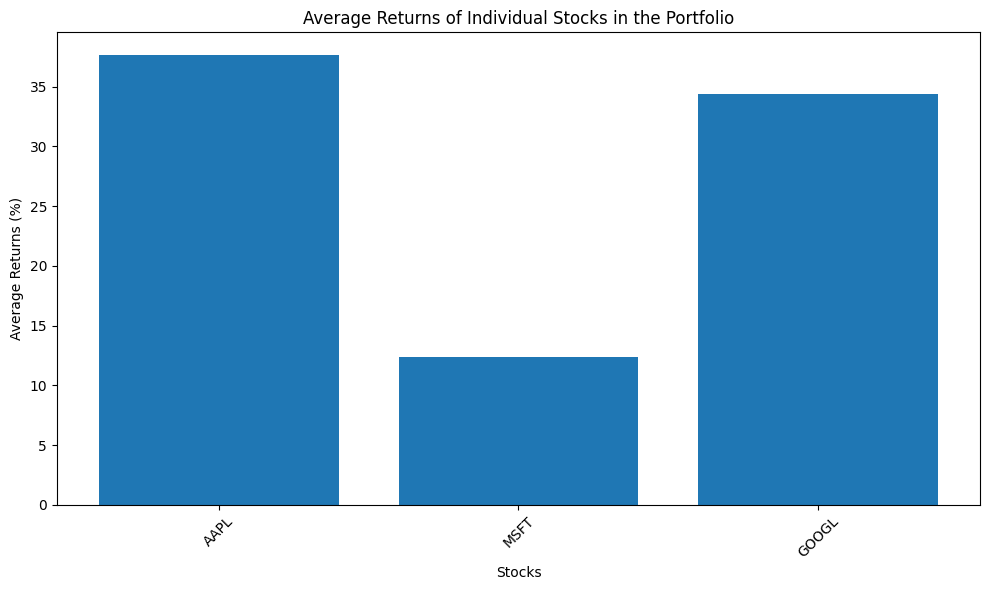

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import yfinance as yf
import datetime
import ipywidgets as widgets
from IPython.display import display

# Function to load historical stock data using yfinance
def import_stock_data(tickers, start='2000-01-01'):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start=start)['Adj Close']
    return data

# Function to perform Monte Carlo simulation for a single stock
def monte_carlo_simulation_single_stock(trials, days, log_returns, current_price, initial_investment, stock_symbol, plot_simulation=True):
    # Calculate drift and volatility
    u = log_returns.mean()
    var = log_returns.var()
    drift = u - (0.5 * var)
    stdev = log_returns.std()

    # Generate random returns
    Z = norm.ppf(np.random.rand(days, trials))
    daily_returns = np.exp(drift + stdev * Z)

    # Simulate price paths
    price_paths = np.zeros((days, trials))
    price_paths[0] = current_price

    for t in range(1, days):
        price_paths[t] = price_paths[t - 1] * daily_returns[t]

    final_prices = price_paths[-1, :]
    portfolio_values = final_prices * (initial_investment / current_price)

    if plot_simulation:
        # Plot Monte Carlo Simulation of stock price
        plot_stock_price_paths(price_paths, stock_symbol)

    # Calculate individual stock returns for each trial
    individual_stock_returns = ((final_prices - current_price) / current_price) * 100

    return portfolio_values, individual_stock_returns

# Function to plot price paths for a single stock
def plot_stock_price_paths(price_paths, stock_symbol):
    plt.figure(figsize=(10, 6))
    for trial in range(price_paths.shape[1]):  # Use shape[1] to get the number of trials
        plt.plot(price_paths[:, trial], linewidth=0.5)
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.title(f'Monte Carlo Simulation of {stock_symbol} Stock Price')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Function to plot the histogram of final stock prices
def plot_final_stock_price_histogram(final_prices, current_price, stock_symbol):
    plt.figure(figsize=(10, 6))
    plt.hist(final_prices, bins=30, edgecolor='k', density=True)
    plt.axvline(x=current_price, color='r', linestyle='dashed', linewidth=2, label=f'Initial investment in {stock_symbol} (${current_price:.2f})')
    plt.xlabel('Stock Price')
    plt.ylabel('Probability Density')
    plt.title(f'Probability Distribution of Final {stock_symbol} Stock Prices')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Function to perform Monte Carlo simulation for a portfolio of stocks
def monte_carlo_simulation_portfolio(stock_tickers, weights, trials, days, initial_investment, plot_stock_simulation=True, stochastic_parameters=True):
    portfolio_returns = []
    portfolio_values = np.zeros((days, trials))
    stock_symbols = []

    # Fetch historical stock data using import_stock_data
    stock_data = import_stock_data(stock_tickers)

    for ticker in stock_tickers:
        stock_symbol = ticker
        stock_prices = stock_data[ticker]
        log_returns = np.log(stock_prices / stock_prices.shift(1))[1:]
        current_price = stock_prices.iloc[-1]

        if stochastic_parameters:
            stock_portfolio_values, individual_stock_returns = stochastic_monte_carlo_simulation_single_stock(trials, days, log_returns, current_price, initial_investment * weights[stock_tickers.index(ticker)], stock_symbol, plot_simulation=plot_stock_simulation)
        else:
            stock_portfolio_values, individual_stock_returns = monte_carlo_simulation_single_stock(trials, days, log_returns, current_price, initial_investment * weights[stock_tickers.index(ticker)], stock_symbol, plot_simulation=plot_stock_simulation)

        portfolio_values += stock_portfolio_values

        average_stock_return = np.mean(individual_stock_returns)  # Calculate the average return for the stock

        portfolio_returns.append(average_stock_return)
        stock_symbols.append(stock_symbol)

        # Plot final stock price histogram
        plot_final_stock_price_histogram(stock_portfolio_values, initial_investment * weights[stock_tickers.index(ticker)], stock_symbol)


    # Plot the histogram of final portfolio values
    final_portfolio_values = portfolio_values[-1, :]
    plt.figure(figsize=(10, 6))
    plt.hist(final_portfolio_values, bins=30, edgecolor='k', density=True)
    plt.axvline(x=initial_investment, color='r', linestyle='dashed', linewidth=2, label=f'Initial investment (${initial_investment:.2f})')
    plt.xlabel('Portfolio Value')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of Final Portfolio Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the pie chart for portfolio composition
    plot_portfolio_pie_chart(weights, stock_symbols)

    # Display stock returns as a bar chart
    display_stock_returns(stock_symbols, portfolio_returns)

# Function to plot a pie chart showing the composition of the portfolio
def plot_portfolio_pie_chart(weights, stock_symbols):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=stock_symbols, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')

    # Increase the title spacing and set a larger title font size
    plt.title('Portfolio Composition', pad=30, fontsize=16)  # Adjust pad and fontsize as needed

    # Customize the legend (labels) with larger font size
    plt.legend(stock_symbols, title='Stock Symbols', fontsize=12, loc='upper left')  # Adjust fontsize as needed

    plt.show()

# Function to display stock returns as a bar chart
def display_stock_returns(stock_symbols, stock_returns):
    plt.figure(figsize=(10, 6))
    plt.bar(stock_symbols, stock_returns)
    plt.xlabel('Stocks')
    plt.ylabel('Average Returns (%)')
    plt.title('Average Returns of Individual Stocks in the Portfolio')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create sliders for number of trials and days using ipywidgets
trials_slider = widgets.IntSlider(value=1000, min=100, max=5000, step=100, description='Trials:')
days_slider = widgets.IntSlider(value=365, min=30, max=730, step=30, description='Days:')

# Define the update function for interactive simulation
def update_simulation(change):
    global trials, days
    trials = trials_slider.value
    days = days_slider.value
    monte_carlo_simulation_portfolio(stock_tickers, weights, trials, days, initial_investment, plot_stock_simulation, stochastic_parameters)

# Attach the update function to the sliders' value change event
trials_slider.observe(update_simulation, 'value')
days_slider.observe(update_simulation, 'value')

# Define the list of stock tickers and their corresponding weights in the portfolio
stock_tickers = ["AAPL", "MSFT", "GOOGL"]  # Replace with your stock tickers
weights = [0.4, 0.3, 0.3]  # Replace with the weights of each stock in the portfolio; the sum must be equal to 1
initial_investment = 1000  # Initial investment amount
trials = trials_slider.value  # Initial number of trials
days = days_slider.value  # Initial number of days

# Enable stock price path visualization with consideration for potential performance slowdown, especially for a large number of trials.
plot_stock_simulation = True

# Simulate a stochastic behavior for parameters
stochastic_parameters = False

# Display the sliders and initial simulation
display(trials_slider, days_slider)
monte_carlo_simulation_portfolio(stock_tickers, weights, trials, days, initial_investment, plot_stock_simulation, stochastic_parameters)
